# Ocular Disease Recognition --> tricks and multi-class predictions
## CNN (Convolutional Neural Networks)

Convolutional Neural Networks, or CNNs for short, are a powerful type of neural network commonly used in computer vision tasks. They are particularly well-suited to tasks like image classification and object detection because they are able to automatically learn and extract relevant features from input images. CNNs consist of multiple layers, each of which performs a different type of processing on the input data. These layers typically include convolutional layers, which extract features from the input images, and pooling layers, which downsample the output of the convolutional layers. By stacking these layers on top of one another, a CNN is able to learn increasingly complex representations of the input data.

In [3]:
# Import necessary packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Dataset



Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.

Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

* Normal (N),
* Diabetes (D),
* Glaucoma (G),
* Cataract (C),
* Age related Macular Degeneration (A),
* Hypertension (H),
* Pathological Myopia (M),
* Other diseases/abnormalities (O)



In [4]:
class_name_dict = {
    "N": "Normal",
    "D": "Diabetes",
    "G": "Glaucoma",
    "C": "Cataract",
    "A": "Age related Macular Degeneration",
    "H": "Hypertension",
    "M": "Pathological Myopia",
}

## 1. Exploration

Read the data from `csv` files.

- What are medically useful labels to train a deep learning network on?
- Are there any biases we need to consider?
- Do we have to worry about "data leakage", something that often comes from having many datapoints for the same patients ?

In [8]:
path_data = "ocular_disease_recognition_processed/"

metadata = pd.read_csv(os.path.join(path_data, "metadata.csv"))
metadata.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,filename,left_cataract,right_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,0_right.jpg,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,1_right.jpg,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,2_right.jpg,0,0
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,4_right.jpg,0,0
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,5_right.jpg,0,0


In [9]:
metadata.shape

(6392, 19)

In [10]:
label_column = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
metadata[label_column].sum(axis=1).value_counts()

1    5391
2     955
3      46
dtype: int64

In [11]:
metadata[label_column].sum(axis=0)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64

## Have a look at some of the images

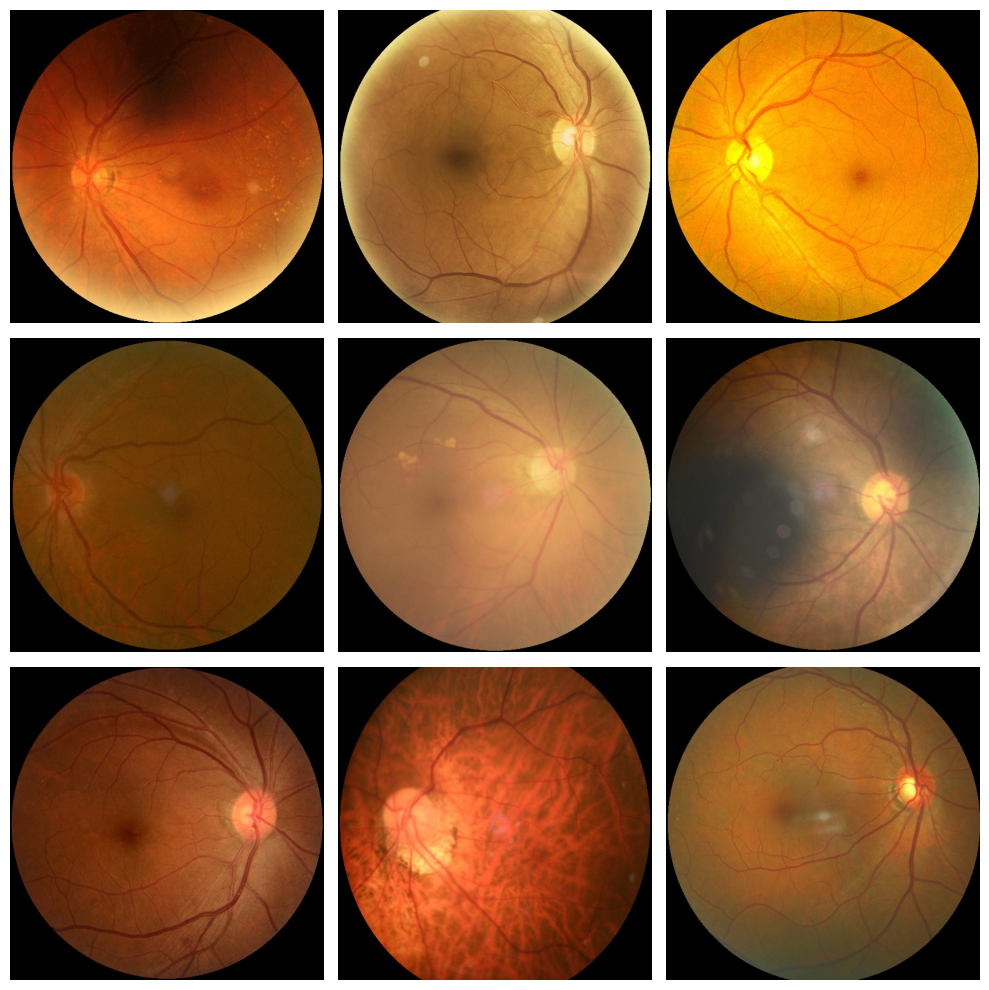

In [15]:
path_images = "ocular_disease_recognition_processed/preprocessed_images"

# Pick 9 random images
np.random.seed(1)
random_images = np.random.choice(metadata.filename, 9)

# Adjust the size of your images
plt.figure(figsize=(10,10))

# Iterate and plot random images
for i, filename in enumerate(random_images):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(path_images, filename))
    plt.imshow(img)
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()    

## Train/Test split

In [16]:
metadata.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,filename,left_cataract,right_cataract
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,0_right.jpg,1,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,1_right.jpg,0,0


In [17]:
metadata.ID.value_counts()

4094    2
2584    2
533     2
4627    2
2576    2
       ..
2930    1
497     1
2571    1
536     1
2244    1
Name: ID, Length: 3358, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(metadata, test_size=0.15,
                                     random_state=0
                                    )
print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (5433, 19)
Test set size: (959, 19)


In [19]:
# second split
train_df, val_df = train_test_split(train_df, test_size=0.15,
                                    random_state=0
                                    )
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")
print(f"Test set size: {test_df.shape}")

Training set size: (4618, 19)
Validation set size: (815, 19)
Test set size: (959, 19)


## Data generators!

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255
)

# Pick your label column(s)
label_column = ['N', 'D', 'G', 'C', 'A', 'H', 'M']

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path_images,
    x_col="filename",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb"
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path_images,
    x_col="filename",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb",
    shuffle=False,  # this is crucial for later evaluation!
)

2023-06-23 10:38:29.997329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 10:38:52.600677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-06-23 10:38:52.600826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

Found 4618 validated image filenames.
Found 815 validated image filenames.


## Let's build a CNN and train it
- last time we used a simple CNN we designed from scratch

In [22]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator


# Define the input shape
inputs = Input(shape=(320, 320, 3))

# Define the CNN architecture
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x) #Dense braucht 1D Daten deshalb flatten wir 
x = Dense(64, activation='relu')(x)
outputs = Dense(len(label_column), activation="sigmoid")(x) #activation ist abhaengig von labels, wir wollen eventuell bei mehreren label eine 1 haben

# Create the model
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 159, 159, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 78, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 76, 76, 128)       7385

In [23]:
import tensorflow as tf

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', #wichtig fuer das Training. Alle nodes sollen einzeln 
              metrics="accuracy") #metrics)

In [24]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10


2023-06-23 10:47:58.734874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-06-23 10:48:23.498181: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fcb540028a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-23 10:48:23.498225: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2023-06-23 10:48:24.110804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-23 10:48:25.948198: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 [==============================] - 94s 255ms/step - loss: 0.3394 - accuracy: 0.3911 - val_loss: 0.3376 - val_accuracy: 0.3080
Epoch 2/10
145/145 [==============================] - 35s 238ms/step - loss: 0.3258 - accuracy: 0.4095 - val_loss: 0.3356 - val_accuracy: 0.3080
Epoch 3/10
145/145 [==============================] - 35s 240ms/step - loss: 0.3234 - accuracy: 0.4134 - val_loss: 0.3277 - val_accuracy: 0.4429
Epoch 4/10
145/145 [==============================] - 35s 237ms/step - loss: 0.3200 - accuracy: 0.4426 - val_loss: 0.3313 - val_accuracy: 0.3718
Epoch 5/10
145/145 [==============================] - 34s 237ms/step - loss: 0.3161 - accuracy: 0.4558 - val_loss: 0.3275 - val_accuracy: 0.4859
Epoch 6/10
145/145 [==============================] - 35s 237ms/step - loss: 0.3141 - accuracy: 0.4502 - val_loss: 0.3208 - val_accuracy: 0.4748
Epoch 7/10
145/145 [==============================] - 34s 236ms/step - loss: 0.3090 - accuracy: 0.4584 - val_loss: 0.3193 - val_accuracy: 0.4

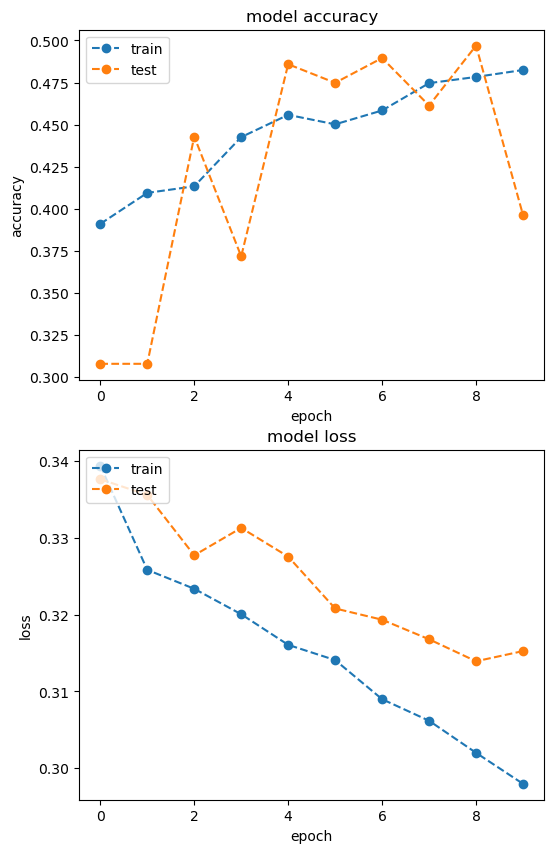

In [25]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], "o--")
ax1.plot(history.history['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], "o--")
ax2.plot(history.history['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

# Model evaluation

In [26]:
y_pred = model.predict(val_generator)
y_true = val_generator.labels

26/26 [==============================] - 5s 180ms/step


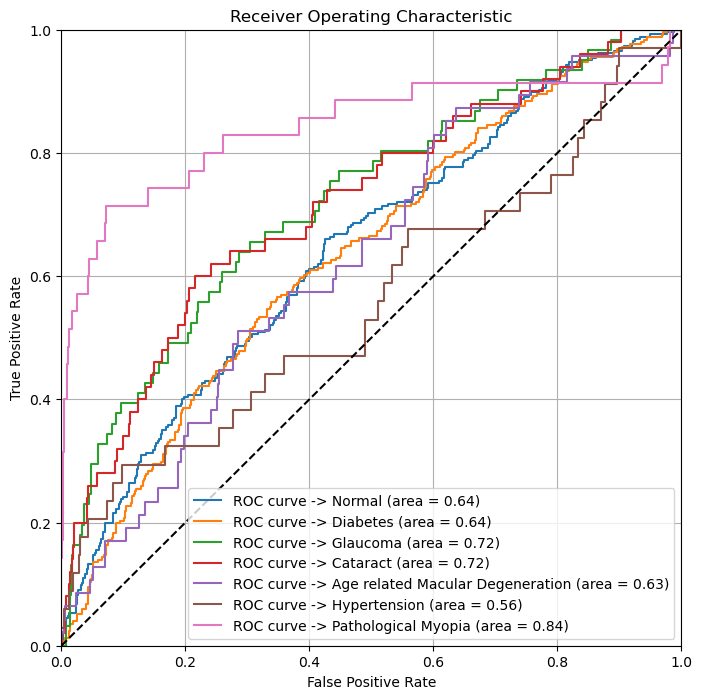

In [27]:
# Code for multi-class model
from sklearn.metrics import roc_curve, auc


# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = label_column

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

# Get class names
class_names = list(classes)

for i, label in enumerate(classes):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {class_name_dict[label]} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

## Use transfer learning!

In [29]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model but exclude the top layer (classification layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Add your own top layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)

# complete code here
x = Dense(64, activation='relu')(x)
outputs = Dense(len(label_column), activation="sigmoid")(x) #activation ist abhaengig von labels, wir wollen eventuell bei mehreren label eine 1 haben

# Create the actual model
model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 326, 326, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

### Account for biases in the data by custom-made loss function

In [30]:
# Calculate class weights
class_weights = train_df[label_column].sum(axis=0)
class_weights = class_weights.sum() / class_weights 

# Ensure class weights sum up to 1
class_weights = class_weights / class_weights.sum()
class_weights

N    0.027544
D    0.026441
G    0.148638
C    0.141080
A    0.188320
H    0.287026
M    0.180951
dtype: float64

In [31]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    class_weights = tf.constant([class_weights[k] for k in sorted(class_weights.keys())], dtype=tf.float32)  # ensure class_weights is float32

    def _weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # ensure y_true is float32
        y_pred = tf.cast(y_pred, tf.float32)  # ensure y_pred is float32
        crossentropy = binary_crossentropy(y_true, y_pred)
        weight_vector = tf.reduce_sum(class_weights * y_true, axis=-1)
        weighted_loss = weight_vector * crossentropy
        return tf.reduce_mean(weighted_loss)

    return _weighted_binary_crossentropy


In [32]:
# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(optimizer=Adam(),
              #loss='binary_crossentropy',
              loss=weighted_binary_crossentropy(class_weights),
              metrics=metrics)

In [33]:
# Train the model
history = model.fit(
    train_generator, 
    validation_data=val_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
145/145 [==============================] - 81s 484ms/step - loss: 0.0466 - accuracy: 0.4794 - precision: 0.4383 - recall: 0.2737 - val_loss: 0.0442 - val_accuracy: 0.5313 - val_precision: 0.5354 - val_recall: 0.2544
Epoch 2/20
145/145 [==============================] - 63s 433ms/step - loss: 0.0425 - accuracy: 0.5297 - precision: 0.5135 - recall: 0.3524 - val_loss: 0.0426 - val_accuracy: 0.5043 - val_precision: 0.5220 - val_recall: 0.3674
Epoch 3/20
145/145 [==============================] - 63s 432ms/step - loss: 0.0415 - accuracy: 0.5390 - precision: 0.5106 - recall: 0.3896 - val_loss: 0.0433 - val_accuracy: 0.4822 - val_precision: 0.4959 - val_recall: 0.4024
Epoch 4/20
145/145 [==============================] - 63s 433ms/step - loss: 0.0408 - accuracy: 0.5507 - precision: 0.5208 - recall: 0.4154 - val_loss: 0.0414 - val_accuracy: 0.5202 - val_precision: 0.5348 - val_recall: 0.4038
Epoch 5/20
145/145 [==============================] - 63s 433ms/step - loss: 0.0399 - accura

Bad pipe message: %s [b'OP\xc9M\x07Vk#s\x90\x11N\x96v\xcc\xc2\xf7? \x11}&\xf6\x9dm', b'P4\xb9\x960\xbb\xae\xee\xfb<\xa4|\xb4\\\x8a\xb5\x10\xe2\x1f\xdf\x97\x1b\xad\x08\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x81]\x00\xb4\x1d\xa7[\x1e\x07\xf0/\x90\xaa\x86P\x97\xbf\xef\x7f\x803\x00']
Bad pipe message: %s [b'8\xcf\xb81D\x8foCv\x83s\xf8G\xb4?\xecc@ -\x9a\x0b\x01\xa2\xbeS\xdd\xf6\x9c;\x16b\xe4\xd4\x06\xee\x81\xd9 \x080\x03&\x9bm\xfc\xf5\x10Qx\xd1\x00\x08\x13\x02\x13\x03\x13', b'']
Bad pipe message: %s [b'\x07\xa4\xf8\xc7\xab\xbc$\xe2\x1a\xb

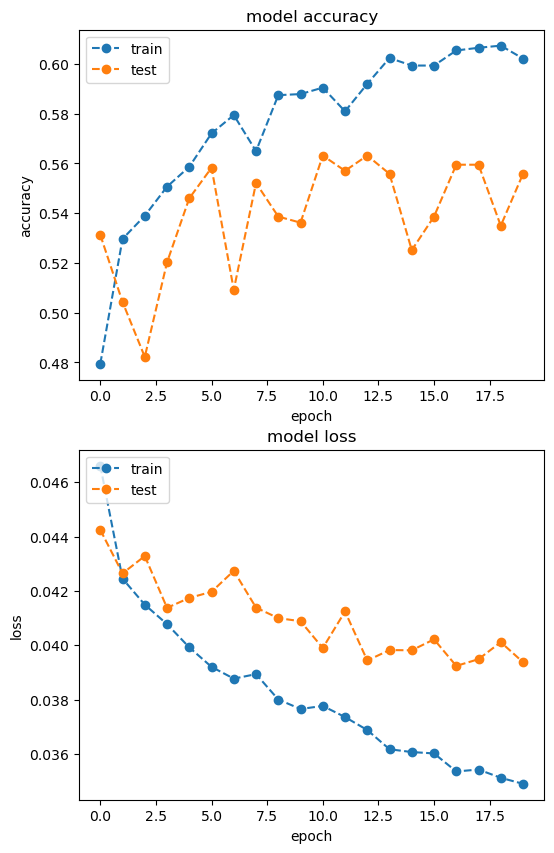

In [34]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], "o--")
ax1.plot(history.history['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], "o--")
ax2.plot(history.history['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate the model

In [35]:
y_pred = model.predict(val_generator)

26/26 [==============================] - 11s 361ms/step


In [36]:
y_true = val_generator.labels

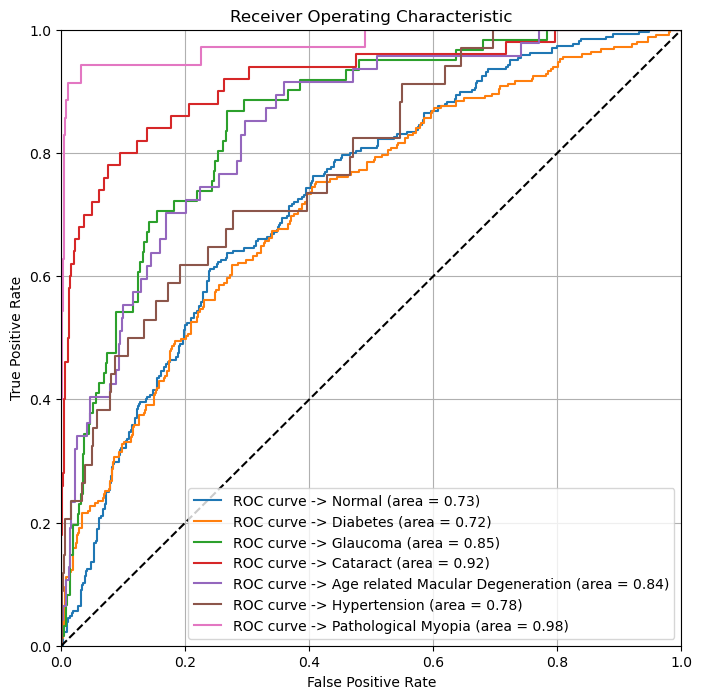

In [37]:
# Code for multi-class model
from sklearn.metrics import roc_curve, auc


# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = label_column

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

# Get class names
class_names = list(classes)

for i, label in enumerate(classes):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {class_name_dict[label]} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

## Improve further....
- Longer training
- Lower learning rate (maybe)
- add data augmentation to image generator (slight rotation and zoom)

## Another option: fine tuning

In [38]:
print(f"Our model has {len(model.layers)} layers!")

Our model has 430 layers!


In [40]:
# Now: unfreeze some of the base model layers and do a second pass of training
for layer in model.layers[:300]:
    layer.trainable = False
for layer in model.layers[300:]:
    layer.trainable = True

# We use a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001),
              #loss='binary_crossentropy',
              loss=weighted_binary_crossentropy(class_weights),
              metrics=['accuracy'])



In [42]:
history = model.fit(
    train_generator, 
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
145/145 [==============================] - 102s 544ms/step - loss: 0.0552 - accuracy: 0.5318 - val_loss: 0.0486 - val_accuracy: 0.4025
Epoch 2/10
145/145 [==============================] - 77s 529ms/step - loss: 0.0273 - accuracy: 0.6773 - val_loss: 0.0412 - val_accuracy: 0.5816
Epoch 3/10
145/145 [==============================] - 77s 531ms/step - loss: 0.0187 - accuracy: 0.7544 - val_loss: 0.0437 - val_accuracy: 0.5816
Epoch 4/10
145/145 [==============================] - 77s 532ms/step - loss: 0.0117 - accuracy: 0.8190 - val_loss: 0.0478 - val_accuracy: 0.5264
Epoch 5/10
145/145 [==============================] - 77s 533ms/step - loss: 0.0076 - accuracy: 0.8482 - val_loss: 0.0483 - val_accuracy: 0.5669
Epoch 6/10
145/145 [==============================] - 77s 534ms/step - loss: 0.0047 - accuracy: 0.8664 - val_loss: 0.0602 - val_accuracy: 0.5018
Epoch 7/10
145/145 [==============================] - 78s 534ms/step - loss: 0.0033 - accuracy: 0.8746 - val_loss: 0.0541 - val_a

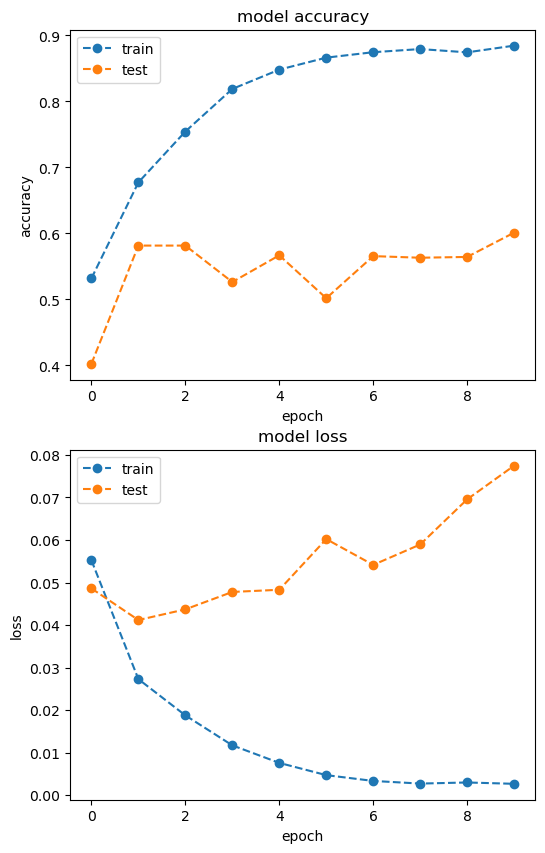

In [43]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], "o--")
ax1.plot(history.history['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], "o--")
ax2.plot(history.history['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate the model

In [44]:
y_pred = model.predict(val_generator)

26/26 [==============================] - 11s 360ms/step


In [45]:
y_true = val_generator.labels

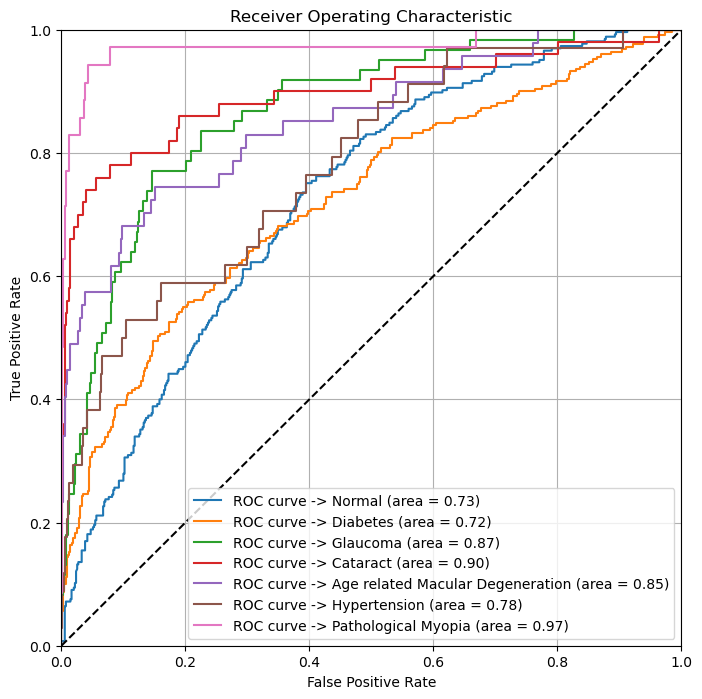

In [46]:
# Code for multi-class model
from sklearn.metrics import roc_curve, auc


# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = label_column

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

# Get class names
class_names = list(classes)

for i, label in enumerate(classes):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {class_name_dict[label]} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()